In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import auc
from scipy.stats import mannwhitneyu
from scipy.stats import norm
from pingouin import mwu

import seaborn as sns


# Data Import

In [2]:
# load the data
df = pd.read_csv('sample_data CRM.csv', delimiter = ';')

df


,customer_id,reporting_date,default_moment,intodefault,mrating,PD
0,1,31.01.2010,30.09.2010,1,21,0.20
1,1,28.02.2010,30.09.2010,1,22,0.25
2,1,31.03.2010,30.09.2010,1,22,0.25
3,1,30.04.2010,30.09.2010,1,22,0.25
4,1,31.05.2010,30.09.2010,1,22,0.25
...,...,...,...,...,...,...
41674,2501,31.07.2011,NaN,0,17,0.06
41675,2501,31.08.2011,NaN,0,17,0.06
41676,2501,30.09.2011,NaN,0,17,0.06
41677,2501,31.10.2011,NaN,0,17,0.06


# PD vs Rating

<AxesSubplot:xlabel='mrating', ylabel='PD'>

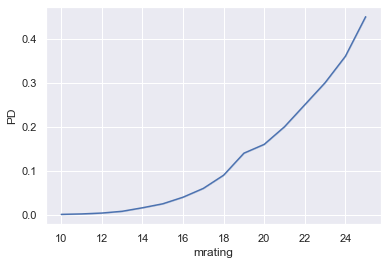

In [3]:
sns.set()
sns.lineplot(data=df, x="mrating", y="PD")


# Portfolio selection
I am making the assumption that I am doing a year-end analysis. If during the year (at the end of the last report) there is a customer default then such an event is treated as a default for the year. In the end, only the 2011 portfolio is analyzed - I don't have more information to study the case in detail.

In [ ]:
# Select portfolio analyzed in 2011
df['reporting_date'] = pd.to_datetime(df['reporting_date'])
df['year'] = pd.DatetimeIndex(df['reporting_date']).year
df = df[df['year'] == 2011]


# Order the portfolio in ascending order by date and group by customer id and select the last element
df = df.sort_values('reporting_date').groupby('customer_id').tail(1)


# ROC

<AxesSubplot:xlabel='portfel', ylabel='default'>

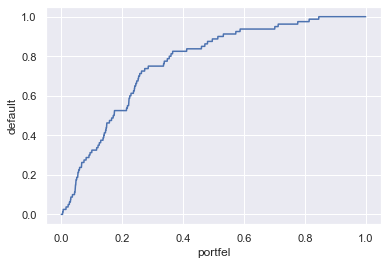

In [5]:
# Ordering the portfolio from the worst rating to the best
df.sort_values('PD', ascending=False, inplace = True)


# Adding the id - numbering the wallet 
ids = []
for i in range(0,len(df['mrating'])):
    ids.append(i+1)
df['id'] = ids


# Determining the proportion of the portfolio
df['portfel'] = (df['id'] / len(df['id']))


# Determining the proportion of defaults
df['default'] = (df['intodefault'].cumsum() / df['intodefault'].sum())


# Determining the ROC curve
sns.lineplot(data=df, x="portfel", y="default")


# AUC

In [6]:
# AUC determined by ROC curve
# Underestimation of AUC by Mann-Whitney U test and Knime analysis system

xx = df['portfel']
yy = df['default']

AUC = auc(xx,yy)

print('computed AUC using sklearn.metrics.auc: {}'.format(auc(xx,yy)))
print('computed AUC using np.trapz: {}'.format(np.trapz(yy, xx)))


computed AUC using sklearn.metrics.auc: 0.7686002337814144
computed AUC using np.trapz: 0.7686002337814144


## Mann-Whitney U Test

In [7]:
# Ordering the portfolio from the worst rating to the best
df.sort_values('PD', inplace = True)


In [8]:
# Split into two sets of data: default and non-default
x = df[df['intodefault'] == 1]
x = x['mrating']

y = df[df['intodefault'] == 0]
y = y['mrating']


In [9]:
# Mann-Whitney U Test (1)
U1, p = mannwhitneyu(x, y)
print("Mann-Whitney U Test (1) - U1: ", U1)


# Mann-Whitney U Test (1)
nx, ny = len(x), len(y)
U2 = nx*ny - U1
print("Mann-Whitney U Test (1) - U2: ", U2)
print("Mann-Whitney U Test (1) - p-val: ", p)
print("")
print("")

# Mann-Whitney U Test (2)
results2 = mwu(x, y, alternative='two-sided')
print("Mann-Whitney U Test (2): ")
print(results2)



Mann-Whitney U Test (1) - U1:  102014.0
Mann-Whitney U Test (1) - U2:  28466.0
Mann-Whitney U Test (1) - p-val:  1.2525989463714974e-17


Mann-Whitney U Test (2): 
        U-val alternative         p-val       RBC      CLES
MWU  102014.0   two-sided  1.252599e-17 -0.563673  0.781836


In [10]:
# AUC
AUC = U1/(nx*ny)
Gini = 2*AUC - 1
print("AUC based on the Mann-Whitney U Test: ", AUC)
print("Gini based on AUC: ", Gini)

# Confidence Interval for AUC
Q1 = AUC/(2-AUC)
Q2 = 2*(AUC**2)/(1+AUC)

SE_AUC = ((AUC*(1-AUC)+(nx-1)*(Q1-AUC**2)+(ny-1)*(Q2-AUC**2))/(nx*ny))**0.5
print("Standard deviation AUC: ", SE_AUC)


AUC based on the Mann-Whitney U Test:  0.7818362967504598
Gini based on AUC:  0.5636725935009197
Standard deviation AUC:  0.03089912460171887


# S Statistic

In [11]:
# Calculate test statistic S 
AUC_Validation = 0.75
S = (AUC_Validation - AUC)/SE_AUC

print("S statistic: ", S)

# One-sided test is specified by: p-value use CDF
p = norm.cdf(S)

print("Test S p-val: ", p)

S statistic:  -1.030330055003851
Test S p-val:  0.1514275475039688
